In [376]:
df = pd.read_csv('/content/drive/MyDrive/MASTER DATA SCIECE/M0. Capstone/Aaron/Trading_Algoritmico-BTC/BTCUSDT_velas_15.csv', sep=',', index_col=0)
df.set_index('Close time', inplace=True)
del df['Open time']
df.drop(['Volume','Number of trades','Quote assert volume',	'Taker buy base asset volume',	'Taker buy quote asset volume',	'Ignore'],inplace=True, axis=1)
df

,Open,High,Low,Close
Close time,,,,
2019-01-01 00:14:59.999,3701.23,3703.72,3689.88,3697.31
2019-01-01 00:29:59.999,3697.91,3698.75,3690.56,3694.20
2019-01-01 00:44:59.999,3693.96,3705.00,3693.00,3702.39
2019-01-01 00:59:59.999,3702.05,3713.00,3695.02,3700.31
2019-01-01 01:14:59.999,3700.20,3702.73,3691.22,3701.03
...,...,...,...,...
2022-12-19 23:14:59.999,16416.82,16459.18,16373.43,16382.34
2022-12-19 23:29:59.999,16382.34,16428.99,16373.14,16423.25
2022-12-19 23:44:59.999,16423.25,16442.35,16410.25,16440.90


In [377]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [378]:
df['diff'] = df['Close'] - df['Close'].shift(1)
df.loc[df['diff'] >= 0, 'Up_DownM'] = 1
df.loc[df['diff'] < 0, 'Up_DownM'] = 0  
df['Up_DownM'] = df['Up_DownM'].shift(-1)   
del df['diff']        
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138840 entries, 2019-01-01 00:14:59.999 to 2022-12-20 00:14:59.999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Open      138840 non-null  float64
 1   High      138840 non-null  float64
 2   Low       138840 non-null  float64
 3   Close     138840 non-null  float64
 4   Up_DownM  138839 non-null  float64
dtypes: float64(5)
memory usage: 6.4+ MB


In [379]:
df_T = df.iloc[-1]
df.drop(index=df.index[-1],inplace=True, axis=0)
print(df_T)

Open        16438.88
High        16456.00
Low         16397.20
Close       16411.28
Up_DownM         NaN
Name: 2022-12-20 00:14:59.999, dtype: float64


# 1 Split the data

In [380]:
target = 'Up_DownM'
features = [i for i in df.columns if i != target]

y = df[target]
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(
                                        X, 
                                        y, 
                                        test_size = 0.3, # tamaño del split aleatorio 
                                        # aunque el split sea aleatorio, stratify garantiza que el ratio de exitos sea el mismo en train y test
                                        random_state = 3 # Guarda el split en el seed 42 por si volvemos a ejecutar la celda, sea el mismo split
                                     )

print('Train data instances:', len(y_train)) #75% data
print('Test data instances:', len(y_test)) #25% data

Train data instances: 97187
Test data instances: 41652


In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138839 entries, 2019-01-01 00:14:59.999 to 2022-12-19 23:59:59.999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Open      138839 non-null  float64
 1   High      138839 non-null  float64
 2   Low       138839 non-null  float64
 3   Close     138839 non-null  float64
 4   Up_DownM  138839 non-null  float64
dtypes: float64(5)
memory usage: 10.4+ MB


# 2 Preprocesing

In [382]:

transform_pipe = ColumnTransformer(transformers = [
    ("scaler", MinMaxScaler(), [0,1,2,3]),
    # ('encoder', OneHotEncoder(), [4])
 
    
  ])

pipe = Pipeline(steps = [
    ("transform", transform_pipe),
    
  ])


In [383]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


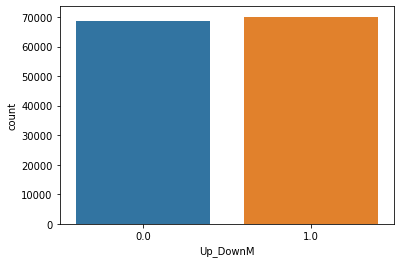

In [384]:
sns.countplot(target, data = df)

# 3 Elegir algoritmo 



In [385]:
# Calculo del AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])  

# Calculo del AUC de un modelo sobre un dataset con Cross-Validation (X-y). Args: modelo a validar, X, y  
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model, X, y, cv=8, scoring='roc_auc')    # Definimos cuantos KFolds (cv) y la metrica validacion (scoring)
  return cross_val.mean()

# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)
def evaluate_classification(label, model, X, y):
  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)                  
  label_.append(label)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)
  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [386]:
evaluate_classification(label='LGBMClassifieR', 
                        model=lgb.LGBMClassifier(), 
                        X=X_train, y=y_train)

# ridge = RidgeClassifier()
# ridge.fit(X_train, y_train)
# y_pred = ridge.predict(X_test)
# print(accuracy_score(y_test,y_pred))

# evaluate_classification(label='XGBoost', 
#                     model = XGBClassifier(), 
#                     X=X_train, y=y_train)

# evaluate_classification(label='GradientBoosting', 
#                         model=GradientBoostingClassifier(), 
#                         X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,LGBMClassifieR,0.564243,0.512927


In [387]:
C = lgb.LGBMClassifier()
model = C.fit(X_train, y_train) 

# 4 Evaluar modelo AUC

AUC Train: 0.5642
AUC Test: 0.5095


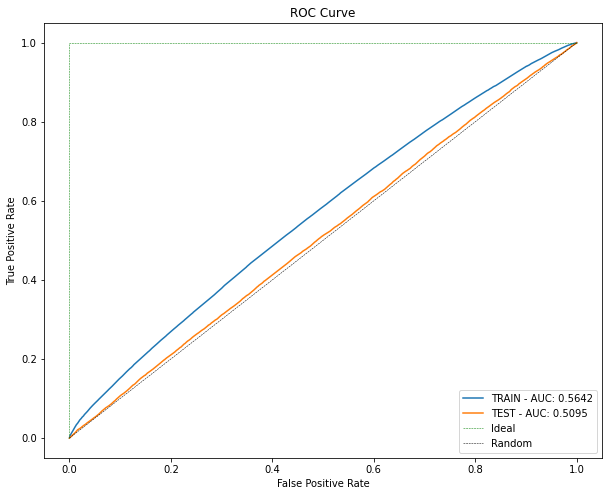

Accuracy: 0.5059
Precision: 0.5102
Recall: 0.5883
F1-score: 0.5465


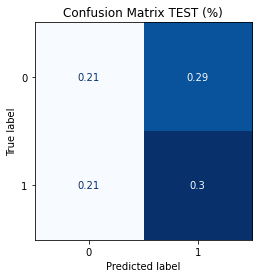

In [388]:
y_train_pred = model.predict(X_train)                        # predicciones del modelo en los datos de TRAIN
y_test_pred = model.predict(X_test)

y_train_pred_proba = model.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = model.predict_proba(X_test)[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred_proba)      # AUC en TRAIN
auc_test = roc_auc_score(y_test, y_test_pred_proba)  

print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

# metrics for ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

print('Accuracy:', round( accuracy_score(y_test, y_test_pred),4))
print('Precision:', round( precision_score(y_test, y_test_pred), 4))
print('Recall:', round( recall_score(y_test, y_test_pred), 4))
print('F1-score:', round(f1_score(y_test, y_test_pred), 4))

# 6 Variables de importancia

In [389]:
len(X.columns.values)

4

In [390]:
np.abs(model.feature_importances_)

array([779, 702, 722, 797])

In [391]:
X.columns.values

array(['Open', 'High', 'Low', 'Close'], dtype=object)

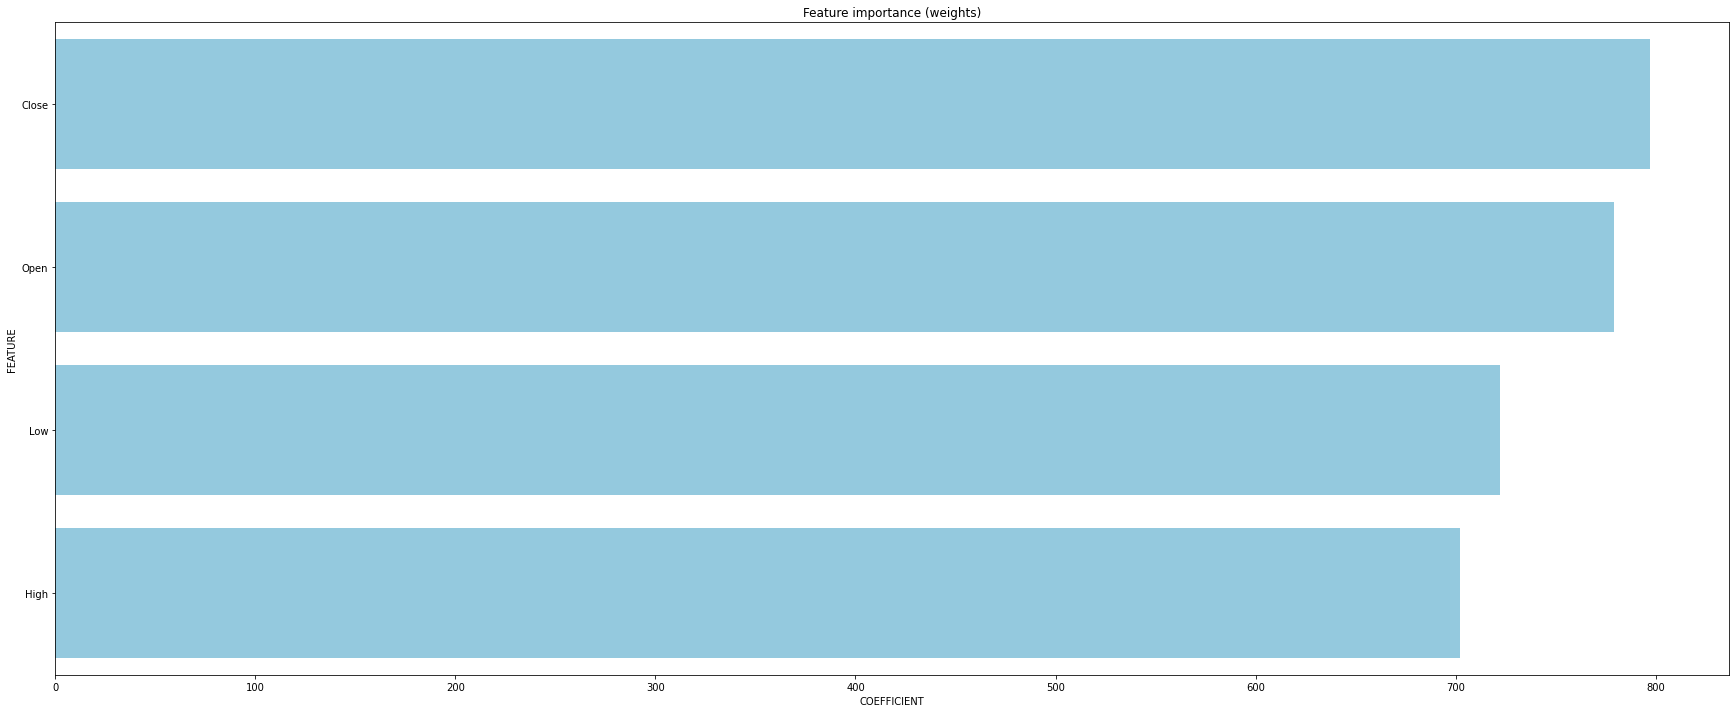

In [392]:
plt.figure(figsize=(30,12))

model.feature_importances_

df_coef = pd.DataFrame({'FEATURE':X.columns.values,
            'COEFFICIENT': np.abs(model.feature_importances_)}).sort_values('COEFFICIENT',ascending=False)
df_coef = sns.barplot(data=df_coef, y='FEATURE',x='COEFFICIENT',color='skyblue')
plt.title('Feature importance (weights)')
plt.show()


# 7 Predict LAG_CLOSE

In [398]:
df_T = pd.DataFrame(df_T)
df_T = df_T.T
df_T



,Open,High,Low,Close,Up_DownM
2022-12-20 00:14:59.999,16438.88,16456.0,16397.2,16411.28,NaN


In [400]:
target = 'Up_DownM'
features = [i for i in df.columns if i != target]

y_pred = df_T[target]
X_pred = df_T[features]

In [401]:
X_pred = pipe.transform(X_pred)
y_pred = model.predict(X_pred)

In [403]:
df_T['Up_DownM'] = y_pred
df = df.append(df_T)
print(y_pred)
df

In [ ]:
df.to_csv()